# A/B Testing: What, Why, When, How
## What & Why
A/B Testing is a general framework of hypothesis testing between two groups to estiblish a causal relationship between actions and resutls, measure impact solely from the change.
## When
change UI design, user flow, add new features
algorithm enhancement, recommendation system, search ranking, ads display
define coupon value, promotion program
marketing optimization
search engine optimization (SEO)
campaign performance measurement
## How
1. design
- Understand problem & objectives
- come up with hypothesis
- design of experiment
2. Implement
- code change & testing
- run experiment & monitor
3. measurement
- result measurement
- data analysis
- decision making


# Mobile Game A/B Testing with Cookie Cats
## 1. Backgroud
Cookie Cats is a mobile puzzle game, a classic 'connect three' style puzzle game where palyer must connect tiles of the same color to clear the board and win the level. As a players progress throught the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make in-app purchase. In addition to driving in-app purchase, these gates also give players an enforced break from playing the game, therefore increase and prolong player's enjoryment.

Where should the gates be placed become important. Initially the first gate was placed at level 30, in this A/B testing we move gate to level 40, and look at the impact on player retention.

## 2. Design - understand problem & objectives
Change: moving the gate from level 30 to level 40
Goal: improve retention rate and conversion rate (in-purchase rate)

## 3. Design - hypothesis
Choose metrics: retention rate
Hypothesis: 
Null: p30 = p40
Alternative: p30 > p40

## 4. Implement - data preparation and description
### Data preparation
#### 4.1 Key assumptions
- the factor to test is the only reason for difference: test(A) and control(B)
- a unit been assigned to A or B is random
- each experiment unit are independent

A/A test can be used to check assumptions random and independent
A/A testing is the tactic of using A/B testing to test two identical versions of a page against each other. This is done to check that the tool being used to run the experiment is statistically fair. In an A/A test, the tool should report no difference in conversions between the control and variation, if the test is implemented correctly

#### 4.2 Assignment Units
Depends on the goal, user_id? Cookie_id? Device_id? Session_id? IP address?
Default is user_id, if there is no login user, then device_id or Cookie_id

Split % - % of users in test / control: usually 50% - 50%
due to time sensitive, eg. holiday marketing campaign

#### 4.3 Exposure & Duration
Don't show A/B versions to all users, it may lead to bad user experience if test version is bad

Minimum sample size:
\begin{align}
n = \frac{2\sigma^2(Z_\beta+Z_{\alpha/2})^2}{difference^2} \\
\end{align}

Daily volume & exposure %
Seasonality, at least one season
Run at least 7 days

### Data preparation
The data is from 90,189 players that installed the game while the A/B test was running. When a player installed the game, he or she was randomly assigned to eith gate_30 or gate_40

- Userid - a unique number that identifies each player
- version - whether the player was put in the control group (gate_3o) or the group with the moved gate (gate_40)
- sun_gamerounds - the number of gam rounds played by the player during the first 14 days after installed
- retention_1 - did the player come back and play 1 day after installing
- retention_7 - did the player come back and play 7 days after installing 

In [3]:
# import dataset
import pandas as pd
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#### Check Sanity
Let's see if there are rougthly the same number of palyers in each A/B group

In [4]:
# sanity check in each group
df.groupby(by='version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


It looks like there is roughly the same number of players in each group

Text(0, 0.5, '# of players')

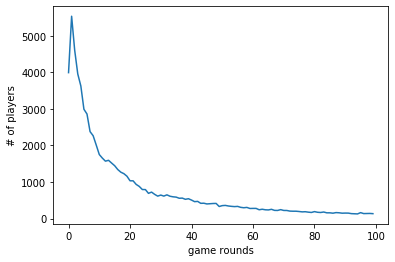

In [6]:
# Check distribution of gamerounds

%matplotlib inline

# count the number of players for each number of gamerounds
plot_df = df.groupby(by='sum_gamerounds').count()['userid']

# plot the distribution of players that played 0 to 100 game round
ax = plot_df.head(100).plot(x='sum_gamerounds', y='userid')
ax.set_xlabel('game rounds')
ax.set_ylabel('# of players')

Data is highly skewed and it's hard to approximate with CLT.

We can use Bootstrap - a resampling method with replacement. Same sample size as the original sample data.

## 5. Measurement - Result Measurement

In [9]:
# the % of users that came back 1 day after installing
df['retention_1'].mean()

0.4452095044850259

Overall 1-day retention rate is 0.4452

In [10]:
# calculate 1-day retention for each group
df.groupby(by='version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

1-day retention slightly decrease when the date was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%)

In [11]:
# the % of users that came back 7 days after installing
df['retention_7'].mean()

0.1860648194347426

Overall 7-day retention rate is 0.1861

In [12]:
# calculate 7-day retention for each group
df.groupby(by='version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

1-day retention slightly decrease when the date was moved to level 40 (18.2%) compared to the control when it was at level 30 (19.0%)